# Quantum Approximate Optimization Algorithm (QAOA)

In [1]:
# import python libraries
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

## Problem definition

Exemplarily, we solve the MaxCut problem: For a given graph, maximize the number of edges cut by a partition of the nodes in two sets.

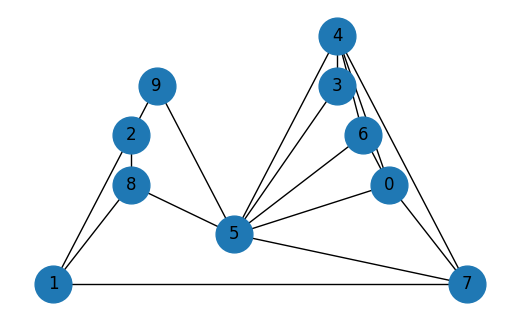

In [2]:
# Define random regular graph
n_wires = 10
while True:
    random_graph = nx.fast_gnp_random_graph(n_wires, 0.5)
    
    # Check if the graph is planar
    is_planar, embedding = nx.check_planarity(random_graph)
    
    if is_planar:
        # Found planar graph
        break
plt.figure(figsize=(5, 3))
nx.draw_planar(random_graph, with_labels=True, node_size=700)
plt.show()

## Define mixer layer $U_\mathrm{M}(\beta_i)$

We can define the mixer layer directly:

In [3]:
def U_M(beta):
    for wire in range(n_wires):
        qml.RX(2*beta, wires=wire)

Alternatively, we can define the cost Hamiltonian to get the mixer layer:

In [4]:
H_M = -1 * qml.PauliX(wires=0)
for wire in range(1, n_wires):
    H_M -= qml.PauliX(wires=wire)
def U_M(beta):
    qml.qaoa.mixer_layer(beta, H_M)

## Define cost layer $U_\mathrm{C}(\gamma_i)$

We use the built-in pennylane cost Hamiltonian for the MaxCut problem to build the cost layer:

In [5]:
H_C, _ = qml.qaoa.maxcut(random_graph)
def U_C(gamma):
    qml.qaoa.cost_layer(gamma, H_C)

## Define QAOA circuit 

In [6]:
depth = 3
wires = range(n_wires)

# define a single qaoa layer
def qaoa_layer(gamma, beta):
    U_C(gamma)
    U_M(beta)

# define the qaoa circuit
def qaoa_circuit(params):
    # Initialize ground state of mixer Hamiltonian
    for wire in wires:
        qml.Hadamard(wires=wire)
    # Apply qaoa layers
    qml.layer(qaoa_layer, depth, params[0], params[1])

## Define cost function

In [7]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    qaoa_circuit(params)
    return qml.expval(H_C)

## Optimize cost function

Initial cost: -9.742000152026668


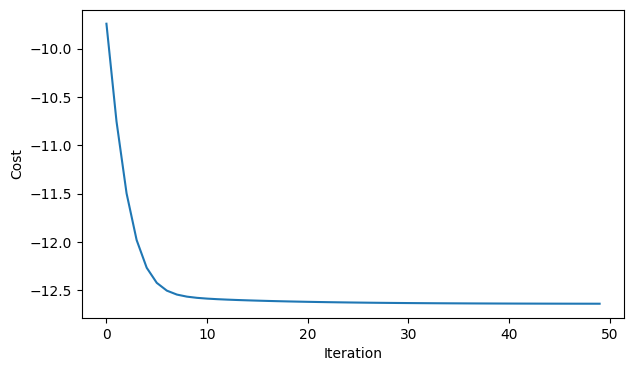

In [8]:
optimizer = qml.GradientDescentOptimizer()
steps = 50
params = np.array([[0.5]*depth, [0.5]*depth], requires_grad=True)
cost_list = []

initial = True

# start optimization
for step in range(steps):
    params, cost = optimizer.step_and_cost(cost_function, params)
    cost_list.append(cost)
    if initial:
        print(f"Initial cost: {cost}")
        initial = False
    print(f"Cost at step {step}: {cost}", end="\r")
plt.figure(figsize=(7, 4))
plt.plot(cost_list)
plt.ylabel("Cost")
plt.xlabel("Iteration")
plt.show()

## Show final probability distribution

In [9]:
@qml.qnode(dev)
def probability_circuit(gamma, beta):
    qaoa_circuit([gamma, beta])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

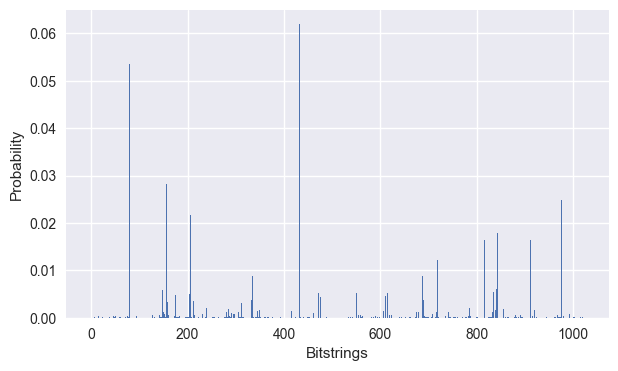

In [10]:
plt.figure(figsize=(7, 4))
plt.style.use('seaborn-v0_8')
plt.bar(range(2 ** len(wires)), probs)
plt.ylabel("Probability")
plt.xlabel("Bitstrings")
plt.show()

## Show cuts with maximal probability

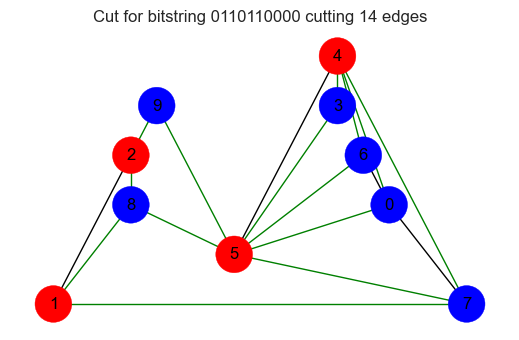

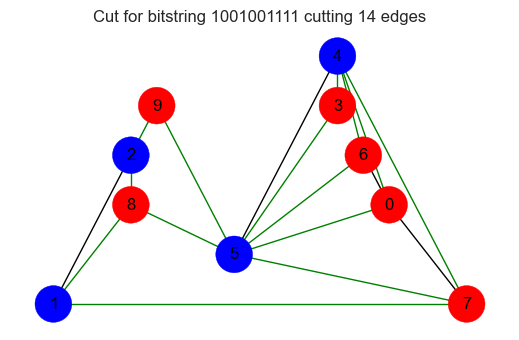

In [11]:
# Find all bitstrings with the maximum probability
max_prob = np.max(probs)
max_prob_indices = np.where(probs == max_prob)[0]  # Find all indices with max probability

# Loop through all bitstrings with maximum probability
for index in max_prob_indices:
    max_prob_bitstring = format(index, f'0{n_wires}b')  # Convert index to binary bitstring
    
    # Determine the cut based on the bitstring
    set_A = {i for i, bit in enumerate(max_prob_bitstring) if bit == '1'}
    set_B = set(range(n_wires)) - set_A
    
    # Visualize the graph with the cut
    colors = ["red" if node in set_A else "blue" for node in random_graph.nodes()]
    edge_colors = ["green" if (u in set_A and v in set_B) or (u in set_B and v in set_A) else "black" for u, v in random_graph.edges()]
    
    # Count and print the number of edges that are cut
    cut_edges = [(u, v) for u, v in random_graph.edges() if (u in set_A and v in set_B) or (u in set_B and v in set_A)]

    plt.figure(figsize=(5, 3))
    nx.draw_planar(random_graph, node_color=colors, edge_color=edge_colors, with_labels=True, node_size=700)
    plt.title(f'Cut for bitstring {max_prob_bitstring} cutting {len(cut_edges)} edges')
    plt.show()